# Explore simulated relationship (part 2)

This notebook is using simulated data generated from [main_Pa_sim_enhance_AtoB](1_main_Pa_sim_enhance_AtoB.ipynb).  This notebook input raw Pseudomonas gene expression data from the Pseudomonas compendium referenced in [ADAGE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5069748/) paper and added a strong nonlinear signal.  This signal assigned a set of genes to group A and a set of genes to group B.  If the expression of genes in group A exceeded some threshold then the genes in group B were upregulated.  

This notebook is extending from the exploration performed in [explore_relationship_AandB_pt1](explore_relationship_AandB_pt1.ipynb).  In this notebook we determined that the modeled/predicted gene expression data between A and B (i.e. after applying a linear transformation in the latent space and decoding) is a mostly linear relationship.  We assume that this means that the *decoder* is learning this linear relationship.  So now we want to determine what the *encoder* is learning. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import seaborn as sns
from keras.models import model_from_json, load_model
from functions import utils
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# Run notebook to generate simulated data
#%run ./main_Pa_sim_enhance_AtoB.ipynb

In [3]:
# Load 
base_dir = os.path.dirname(os.getcwd())
analysis_name = 'sim_distAB_1000AB'

sim_data_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "train_model_input.txt.xz"
)

A_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "geneSetA.txt"
)

B_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "geneSetB.txt"
)

offset_vae_file = os.path.join(
    os.path.dirname(os.getcwd()), 
    "encoded",
    analysis_name, 
    "offset_latent_space_vae.txt"
)

weight_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    analysis_name,
    "VAE_weight_matrix.txt"
)

model_encoder_file = glob.glob(os.path.join(
    base_dir,
    "models",
    analysis_name,
    "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(
    os.path.join(
        base_dir,
        "models",
        analysis_name,
        "*_encoder_weights.h5"
    )
)[0]

model_decoder_file = glob.glob(
    os.path.join(
        base_dir,
        "models",
        analysis_name, 
        "*_decoder_model.h5"
    )
)[0]

weights_decoder_file = glob.glob(
    os.path.join(
        base_dir,
        "models", 
        analysis_name, 
        "*_decoder_weights.h5"
    )
)[0]

In [4]:
# Read data
sim_data = pd.read_table(sim_data_file, index_col=0, header=0, compression='xz')
geneSetA = pd.read_table(A_file, header=0, index_col=0)
geneSetB = pd.read_table(B_file, header=0, index_col=0)

print(sim_data.shape)
sim_data.head()

(1191, 2000)


,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA5348,PA4148,PA2158,PA2839,PA2410,PA0090,PA4963,PA3790,PA0969,PA4776
0.1_12hr_CSV86(Pae_G1a).CEL,0.065748,0.898940,0.61319,0.00000,0.26856,1.00000,0.00000,0.328430,1.00000,0.15330,...,0.039832,0.25410,0.30768,0.16118,0.37444,0.64132,0.35989,0.29978,0.47914,0.45004
0.1_2hr_CSV86(Pae_G1a).CEL,0.000000,0.019449,0.93850,0.84441,0.00000,0.32102,0.68539,0.657000,0.00000,0.60400,...,0.789690,0.62387,0.78148,0.85041,0.93546,0.70920,0.61820,0.78773,0.97945,0.76795
0.1_6hr_CSV86(Pae_G1a).CEL,0.311490,0.933630,0.34831,0.35509,0.22757,0.54608,0.49297,0.565050,0.54114,0.00000,...,0.872670,0.78931,0.92892,0.94578,0.89772,0.79785,0.97098,0.93249,0.75492,0.82408
0.1_7hr_CSV86(Pae_G1a).CEL,0.590760,0.000000,0.32086,0.57895,0.75095,0.94217,0.67022,0.075776,0.43977,1.00000,...,0.928860,1.00000,0.90181,0.73394,0.97635,0.87585,0.85825,0.63930,0.76092,0.91443
0.1_9hr_CSV86(Pae_G1a).CEL,0.370830,0.700460,0.55437,0.65881,0.39321,0.89321,1.00000,0.000000,0.38810,0.79718,...,0.693930,0.67149,0.90713,0.99109,0.86492,0.74021,0.66021,0.75277,0.85820,0.89706


## 1. Trend of gene B with respect to A (input)

How is B changing with respect to A in our simulated dataset (before the data goes into the autoencoder)?

Plot gene expression of A vs mean(gene B expression).  This plot will serve as a reference against later plots that will show the relationship between A and B after transforming the data (i.e. after the data has been fed through the autoencoder)

In [5]:
# Get the means of ORIGINAL B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = sim_data[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean_original_all = geneSetB_exp.mean(axis=1)
geneSetB_mean_original_all.head()

0.1_12hr_CSV86(Pae_G1a).CEL    0.381348
0.1_2hr_CSV86(Pae_G1a).CEL     0.805404
0.1_6hr_CSV86(Pae_G1a).CEL     0.797817
0.1_7hr_CSV86(Pae_G1a).CEL     0.795529
0.1_9hr_CSV86(Pae_G1a).CEL     0.797226
dtype: float64

In [6]:
# Get the means of ORIGINAL A genes

# Convert dataframe with gene ids to list
geneSetA_ls = geneSetA['gene id'].values.tolist()

geneSetA_exp = sim_data[geneSetA_ls]

# Get the mean for each sample
geneSetA_mean_original_all = geneSetA_exp.mean(axis=1)
geneSetA_mean_original_all.head()

0.1_12hr_CSV86(Pae_G1a).CEL    0.488785
0.1_2hr_CSV86(Pae_G1a).CEL     0.504159
0.1_6hr_CSV86(Pae_G1a).CEL     0.519795
0.1_7hr_CSV86(Pae_G1a).CEL     0.509011
0.1_9hr_CSV86(Pae_G1a).CEL     0.506159
dtype: float64

In [7]:
# Join original expression of A and mean(transformed expression of B)
original_A_mean_exp = geneSetA_mean_original_all
original_B_mean_exp = geneSetB_mean_original_all

original_A_vs_original_B_df = pd.merge(original_A_mean_exp.to_frame('mean gene A untransformed'),
                      original_B_mean_exp.to_frame('mean gene B untransformed'),
                      left_index=True, right_index=True)
original_A_vs_original_B_df.head()

,mean gene A untransformed,mean gene B untransformed
0.1_12hr_CSV86(Pae_G1a).CEL,0.488785,0.381348
0.1_2hr_CSV86(Pae_G1a).CEL,0.504159,0.805404
0.1_6hr_CSV86(Pae_G1a).CEL,0.519795,0.797817
0.1_7hr_CSV86(Pae_G1a).CEL,0.509011,0.795529
0.1_9hr_CSV86(Pae_G1a).CEL,0.506159,0.797226


**Plot**
The plot below shows the signal that was added to the dataset.  This signal assigned a set of genes to group A and a set of genes to group B. If the expression of genes in group A exceeded some threshold then the genes in group B were upregulated.  

So we see a step function relationship between the expression of genes in group A and the expression of genes in group B.  With a threshold of 0.5 we can see that the expression of genes in B are upregulated.

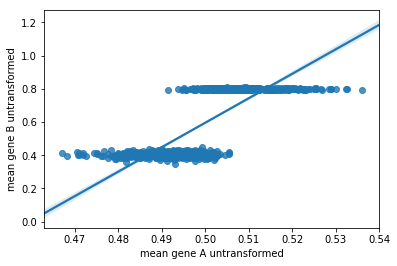

In [8]:
# Plot
sns.regplot(x='mean gene A untransformed',
            y='mean gene B untransformed',
           data = original_A_vs_original_B_df)

## 3.  Trend of gene B with respect to A (encoder)

How is B changing with respect to A after shifting input expression and then applying our latent space transformation?

Here we are only changing samples **before** they have been encoded into the latent space and then we apply our latent space transformation.  If we compare these trends with those from #2 module, which show what the decoder is supposedly learning, then we can conclude what the encoder is learning.

In order to test this we manually shift A genes from being below the activation threshold to being above it and see how the gene expression data is reconstructed

In [9]:
# Artificially shift gene A expression

# Get single sample
test_sample = geneSetA_mean_original_all[geneSetA_mean_original_all == min(geneSetA_mean_original_all)].index[0]
print(test_sample)

# Sample with original value of gene A
A_exp_sample = sim_data.loc[test_sample]

A_exp_sample_modified_df = pd.DataFrame()

A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

# Convert dataframe with gene ids to list
geneSetA_ls = geneSetA['gene id'].values.tolist()

# Artificially shift genes in set A
mu_As = np.linspace(0.45, 0.55, num=100)
geneSetA_size = len(geneSetA_ls)

for i in mu_As:
    sigma_A = 0.1
    new_geneA_dist = np.random.normal(i, sigma_A, geneSetA_size)
    sim_data.loc[test_sample,geneSetA_ls] = new_geneA_dist 
    A_exp_sample = sim_data.loc[test_sample]
    A_exp_sample_modified_df = A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

A_exp_sample_modified_df.head()

GSM774162_PAO1c.CEL


,PA0002,PA0003,PA0007,PA0009,PA0010,PA0014,PA0015,PA0017,PA0019,PA0020,...,PA5543,PA5544,PA5552,PA5554,PA5556,PA5560,PA5565,PA5566,PA5567,PA5568
0,0.329806,0.360680,0.25423,0.89583,0.409416,0.556992,0.50185,0.449369,0.322643,0.535655,...,0.15488,0.298189,0.293156,0.90005,0.404643,0.429334,0.91275,0.1578,0.80773,0.88472
1,0.414093,0.552172,0.25423,0.89583,0.479455,0.339018,0.50185,0.389313,0.329444,0.415702,...,0.15488,0.414329,0.554430,0.90005,0.342969,0.332321,0.91275,0.1578,0.80773,0.88472
2,0.453730,0.369600,0.25423,0.89583,0.425205,0.357400,0.50185,0.452626,0.524714,0.553599,...,0.15488,0.354719,0.321810,0.90005,0.564343,0.309103,0.91275,0.1578,0.80773,0.88472
3,0.426662,0.635862,0.25423,0.89583,0.497336,0.271226,0.50185,0.447780,0.369926,0.470515,...,0.15488,0.626151,0.549495,0.90005,0.442716,0.307923,0.91275,0.1578,0.80773,0.88472
4,0.517083,0.656853,0.25423,0.89583,0.456250,0.312177,0.50185,0.559084,0.315138,0.665910,...,0.15488,0.578864,0.303839,0.90005,0.349975,0.478697,0.91275,0.1578,0.80773,0.88472


In [10]:
# Define function to apply latent space transformation to SHIFTED data and output reconstructed data

def interpolate_in_vae_latent_space_shiftA(all_data, 
                                       sample_data,
                                       model_encoder_file,
                                       model_decoder_file,
                                       weights_encoder_file,
                                       weights_decoder_file,
                                       encoded_dir,
                                       percent_low,
                                       percent_high,
                                       out_dir):
    """
    interpolate_in_vae_latent_space(all_data: dataframe,
                                    sample_data: dataframe,
                                    model_encoder_file: string,
                                    model_decoder_file: string,
                                    weights_encoder_file: string,
                                    weights_decoder_file: string,
                                    encoded_dir: string,
                                    gene_id: string,
                                    percent_low: integer,
                                    percent_high: integer,
                                    out_dir: string):

    input:
        all_data: Dataframe with gene expression data from all samples
        
        sample_data:  Dataframe with gene expression data from subset of samples (around the treshold)

        model_encoder_file: file containing the learned vae encoder model

        model_decoder_file: file containing the learned vae decoder model
        
        weights_encoder_file: file containing the learned weights associated with the vae encoder model
        
        weights_decoder_file: file containing the learned weights associated with the vae decoder model
        
        encoded_dir:  directory to use to output offset vector to 

        gene_id: gene you are using as the "phenotype" to sort samples by 

                 This gene is referred to as "target_gene" in comments below


        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1
        
        out_dir: directory to output predicted gene expression to

    computation:
        1.  Sort samples based on the expression level of the target gene defined by the user
        2.  Sample_data are encoded into VAE latent space
        3.  We predict the expression profile of the OTHER genes at a given level of target gene 
            expression by adding a scale factor of offset vector to the sample

            The scale factor depends on the distance along the target gene expression gradient
            the sample is.  For example the range along the target gene expression is from 0 to 1.  
            If the sample of interest has a target gene expression of 0.3 then our prediction
            for the gene expression of all other genes is equal to the gene expression corresponding
            to the target gene expression=0 + 0.3*offset latent vector
        3.  Prediction is decoded back into gene space
        4.  This computation is repeated for all samples 

    output: 
         1. encoded predicted expression profile per sample
         2. predicted expression profile per sample

    """

    # Load arguments
    offset_file = os.path.join(encoded_dir, "offset_latent_space_vae.txt")

    # Output file
    predict_file = os.path.join(out_dir, "shifted_predicted_gene_exp.txt")
    predict_encoded_file = os.path.join(out_dir, "shifted_predicted_encoded_gene_exp.txt")  
    
    # read in saved VAE models
    loaded_model = load_model(model_encoder_file)
    loaded_decoder_model = load_model(model_decoder_file)

    # load weights into models
    loaded_model.load_weights(weights_encoder_file)
    loaded_decoder_model.load_weights(weights_decoder_file)
    
    # Initialize dataframe for predicted expression of sampled data
    predicted_sample_data = pd.DataFrame(columns=sample_data.columns)
    predicted_encoded_sample_data = pd.DataFrame()
    
    sample_ids = sample_data.index
    for sample_id in sample_ids:
        sample_exp = sample_data.loc[sample_id].to_frame().T
        
        # Use trained model to encode expression data into SAME latent space
        predict = loaded_model.predict_on_batch(sample_exp)

        predict_encoded_df = pd.DataFrame(predict)
        
        predicted_encoded_sample_data = (
            predicted_encoded_sample_data
            .append(predict_encoded_df, ignore_index=True)
        )
        
        # Decode prediction
        predict_decoded = loaded_decoder_model.predict_on_batch(predict_encoded_df)
        predict_df = pd.DataFrame(
            predict_decoded, columns=sample_data.columns)
        
        predicted_sample_data = (
            predicted_sample_data
            .append(predict_df, ignore_index=True)
        )

    predicted_sample_data.set_index(sample_data.index, inplace=True)
    predicted_encoded_sample_data.set_index(sample_data.index, inplace=True)
    
    # Output estimated gene experession values
    predicted_sample_data.to_csv(predict_file, sep='\t')
    predicted_encoded_sample_data.to_csv(predict_encoded_file, sep='\t')

In [11]:
# Apply function 
out_dir = os.path.join(base_dir, "output", analysis_name)
encoded_dir = os.path.join(base_dir, "encoded", analysis_name)

percent_low = 5
percent_high = 95
interpolate_in_vae_latent_space_shiftA(sim_data,
                                   A_exp_sample_modified_df,
                                   model_encoder_file,
                                   model_decoder_file,
                                   weights_encoder_file,
                                   weights_decoder_file,
                                   encoded_dir,
                                   percent_low,
                                   percent_high,
                                   out_dir)

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
# Read dataframe with gene expression transformed
predict_file = os.path.join(base_dir, "output", analysis_name, "shifted_predicted_gene_exp.txt")
predict_gene_exp = pd.read_table(predict_file, header=0, index_col=0)

print(predict_gene_exp.shape)
predict_gene_exp.head()

(100, 2000)


,PA0002,PA0003,PA0007,PA0009,PA0010,PA0014,PA0015,PA0017,PA0019,PA0020,...,PA5543,PA5544,PA5552,PA5554,PA5556,PA5560,PA5565,PA5566,PA5567,PA5568
0,0.502564,0.496413,0.492944,0.489103,0.490971,0.476231,0.508421,0.484849,0.508823,0.470500,...,0.611784,0.198850,0.299635,0.219586,0.437674,0.439927,0.516796,0.412408,0.600539,0.402798
1,0.502608,0.496591,0.492832,0.489006,0.490978,0.476483,0.508468,0.484809,0.508882,0.470553,...,0.611690,0.200087,0.300438,0.220446,0.438036,0.440215,0.516834,0.412684,0.600116,0.403252
2,0.502560,0.496440,0.492913,0.489072,0.490948,0.476303,0.508409,0.484893,0.508850,0.470525,...,0.611686,0.199237,0.299939,0.219893,0.437803,0.439988,0.516768,0.412485,0.600332,0.402925
3,0.502805,0.497235,0.492471,0.488707,0.491086,0.477282,0.508709,0.484494,0.509035,0.470695,...,0.611646,0.203950,0.302752,0.222989,0.439103,0.441211,0.517094,0.413579,0.599081,0.404711
4,0.502605,0.496651,0.492768,0.488943,0.490936,0.476631,0.508448,0.484888,0.508937,0.470602,...,0.611503,0.200884,0.301051,0.221070,0.438297,0.440344,0.516785,0.412845,0.599706,0.403516


In [13]:
# Get the means of ORIGINAL B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = A_exp_sample_modified_df[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean_original = geneSetB_exp.mean(axis=1)
geneSetB_mean_original.head()

0    0.41219
1    0.41219
2    0.41219
3    0.41219
4    0.41219
dtype: float64

In [14]:
# Get the means of ORIGINAL A genes

# Convert dataframe with gene ids to list
geneSetA_ls = geneSetA['gene id'].values.tolist()

geneSetA_exp = A_exp_sample_modified_df[geneSetA_ls]

# Get the mean for each sample
geneSetA_mean_original = geneSetA_exp.mean(axis=1)
geneSetA_mean_original.head()

0    0.446044
1    0.451849
2    0.453056
3    0.459678
4    0.460016
dtype: float64

In [15]:
# Get the means of TRANSFORMED B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = predict_gene_exp[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean_transformed = geneSetB_exp.mean(axis=1)
geneSetB_mean_transformed.head()

0    0.457477
1    0.457662
2    0.457534
3    0.458243
4    0.457779
dtype: float64

In [16]:
# Get the means of TRANSFORMED A genes

# Convert dataframe with gene ids to list
geneSetA_ls = geneSetA['gene id'].values.tolist()

geneSetA_exp = predict_gene_exp[geneSetA_ls]

# Get the mean for each sample
geneSetA_mean_transformed = geneSetA_exp.mean(axis=1)
geneSetA_mean_transformed.head()

0    0.454224
1    0.454420
2    0.454287
3    0.455023
4    0.454550
dtype: float64

**Plot:** Original A vs Transformed A

In [17]:
# Join original expression of A and transformed expression of A
original_A_mean_exp = geneSetA_mean_original
predict_A_mean_exp = geneSetA_mean_transformed

original_A_vs_transformed_A_df = pd.merge(original_A_mean_exp.to_frame('mean gene A untransformed'),
                                          predict_A_mean_exp.to_frame('mean gene A transformed'),
                                          left_index=True, right_index=True)

original_A_vs_transformed_A_df.head()

,mean gene A untransformed,mean gene A transformed
0,0.446044,0.454224
1,0.451849,0.454420
2,0.453056,0.454287
3,0.459678,0.455023
4,0.460016,0.454550


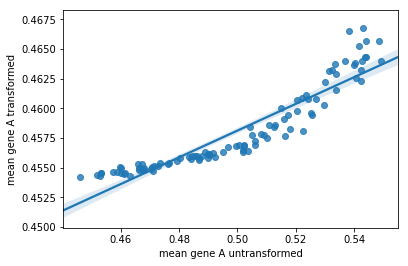

In [18]:
# Plot
sns.regplot(x='mean gene A untransformed',
            y='mean gene A transformed',
           data = original_A_vs_transformed_A_df)

**Plot:** Original A vs Mean(Transformed B)

In [19]:
# Join original expression of A and mean(transformed expression of B)
original_A_mean_exp = geneSetA_mean_original
predict_B_mean_exp = geneSetB_mean_transformed

original_A_vs_transformed_B_df = pd.merge(original_A_mean_exp.to_frame('mean gene A untransformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)

original_A_vs_transformed_B_df.head()

,mean gene A untransformed,mean gene B transformed
0,0.446044,0.457477
1,0.451849,0.457662
2,0.453056,0.457534
3,0.459678,0.458243
4,0.460016,0.457779


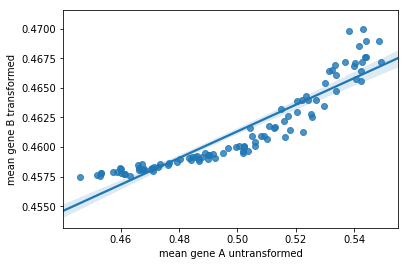

In [20]:
# Plot
# A before transformation vs B after transformation
sns.regplot(x='mean gene A untransformed',
            y='mean gene B transformed',
           data = original_A_vs_transformed_B_df)

**Plot:** Transformed A vs Mean(Transformed B)

In [21]:
# Join original expression of transformed A and mean(transformed expression of B)
predict_A_mean_exp = geneSetA_mean_transformed
predict_B_mean_exp = geneSetB_mean_transformed

transformed_A_vs_transformed_B_df = pd.merge(predict_A_mean_exp.to_frame('mean gene A transformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)
transformed_A_vs_transformed_B_df.head()

,mean gene A transformed,mean gene B transformed
0,0.454224,0.457477
1,0.454420,0.457662
2,0.454287,0.457534
3,0.455023,0.458243
4,0.454550,0.457779


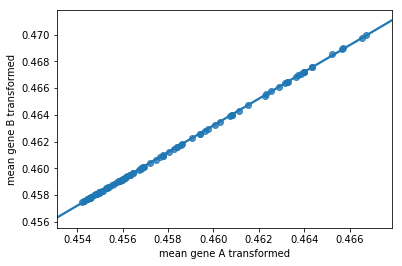

In [22]:
# Plot
sns.regplot(x='mean gene A transformed',
            y='mean gene B transformed',
           data = transformed_A_vs_transformed_B_df)